In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.kernel.sqrt import UnarySqrt
from UnarySim.sw.bitstream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib.pyplot as plt
import time
import math
import numpy as np

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
rng = "Sobol"

In [4]:
def test(mode = "unipolar", bitwidth = 8, jk_trace = False, emit = True):
    bstype = torch.float
    randtype = torch.float
    # input = torch.tensor([x for x in range(2**bitwidth)]).type(torch.float).div(2**bitwidth).to(device)
    input = torch.tensor([x for x in range(2**(bitwidth-2), 2**bitwidth)]).type(torch.float).div(2**bitwidth).to(device)
    print("min: ", input.min().item(), "max: ", input.max().item())
    
    dut_sqrt = UnarySqrt(mode=mode, jk_trace=jk_trace, depth=4, rng="Sobol", rng_dim=4, emit=emit, depth_emit=3, bstype=torch.float).to(device)

    output = torch.sqrt(input).to(device)
    outPE = ProgressiveError(output, mode=mode).to(device)

    inputPE = ProgressiveError(input, mode=mode).to(device)
    inputSRC = SourceGen(input, bitwidth, mode=mode, randtype=randtype)().to(device)
    inputRNG = RNG(bitwidth, 1, rng, randtype)().to(device)
    inputBS = BSGen(inputSRC, inputRNG, bstype).to(device)
    
    pp_rmse = []
    
    with torch.no_grad():
        start_time = time.time()
        for i in range(2**bitwidth):
            input_bs = inputBS(torch.tensor([i]))
            inputPE.Monitor(input_bs)

            out_bs = dut_sqrt(input_bs)
            outPE.Monitor(out_bs)
            pp_rmse.append(1 - torch.sqrt(torch.mean(torch.mul(outPE()[1], outPE()[1]))).item())
        print("--- %s seconds ---" % (time.time() - start_time))
        print("input error: ", torch.min(inputPE()[1]), torch.max(inputPE()[1]))
        print("output error: ", torch.min(outPE()[1]), torch.max(outPE()[1]))
        
        
        final_rmse = outPE()[1].view(-1).cpu().numpy()
        print("RMSE", math.sqrt(np.mean(final_rmse**2)))
        print("MAE", np.mean(np.abs(final_rmse)))
        print("bias", np.mean(final_rmse))
        print("error distribution=========>")
        plt.figure(figsize=(3,1.5))
        fig = plt.plot(input.cpu().numpy(), final_rmse)  # arguments are passed to np.histogram
        plt.title("data: "+mode)
        plt.show()
        
        print("progressive accuracy=========>")
        plt.figure(figsize=(3,1.5))
        fig = plt.plot(pp_rmse)  # arguments are passed to np.histogram
        plt.title("data: "+mode)
        plt.show()

min:  0.25 max:  0.99609375
--- 1.0529978275299072 seconds ---
input error:  tensor(-0.0039, device='cuda:0') tensor(0.0039, device='cuda:0')
output error:  tensor(-0.0624, device='cuda:0') tensor(0.1018, device='cuda:0')
RMSE 0.04126559870867847
MAE 0.029366083
bias 0.024102954
error distribution=========>


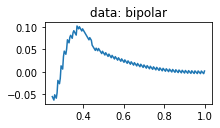

progressive accuracy=========>


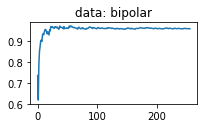

In [5]:
test(mode = "bipolar", bitwidth = 8, emit = True, jk_trace = False)

min:  0.25 max:  0.99609375
--- 0.5919992923736572 seconds ---
input error:  tensor(-0.0039, device='cuda:0') tensor(0.0039, device='cuda:0')
output error:  tensor(-0.1289, device='cuda:0') tensor(0.0457, device='cuda:0')
RMSE 0.042497961509514015
MAE 0.028194478
bias -0.007269118
error distribution=========>


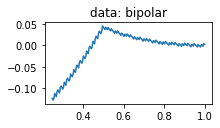

progressive accuracy=========>


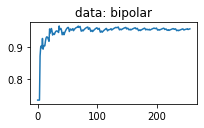

In [6]:
test(mode = "bipolar", bitwidth = 8, emit = False, jk_trace = True)

min:  0.25 max:  0.99609375
--- 0.6929976940155029 seconds ---
input error:  tensor(-0.0039, device='cuda:0') tensor(0.0039, device='cuda:0')
output error:  tensor(-0.0038, device='cuda:0') tensor(0.1250, device='cuda:0')
RMSE 0.049758443213131186
MAE 0.035299394
bias 0.035048593
error distribution=========>


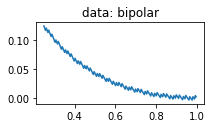

progressive accuracy=========>


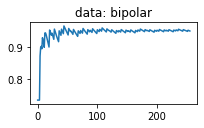

In [7]:
test(mode = "bipolar", bitwidth = 8, emit = False, jk_trace = False)